In [1]:
import sys
import torch
import os
import math
from os import makedirs
import numpy as np
import open3d as o3d
from random import randint
from scipy.spatial.transform import Rotation
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import random
import open3d as o3d

np.set_printoptions(suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def readFileMatrix(file_path):
    # Read the file
    with open(file_path, 'r') as file:
        lines = file.readlines()
    # Parse the matrix values
    matrix = []
    for line in lines:
        values = line.strip().split()
        row = [float(value) for value in values]
        matrix.append(row)

    # Convert the matrix to a numpy array
    matrix = np.array(matrix)
    return matrix

extrinsic_color = readFileMatrix('./intrinsic/extrinsic_color.txt')
extrinsic_depth = readFileMatrix('./intrinsic/extrinsic_depth.txt')
intrinsic_color = readFileMatrix('./intrinsic/intrinsic_color.txt')
intrinsic_depth = readFileMatrix('./intrinsic/intrinsic_depth.txt')

print('extrinsic_color:\n', extrinsic_color)
print('extrinsic_depth:\n', extrinsic_depth)
print('intrinsic_color:\n', intrinsic_color)
print('intrinsic_depth:\n', intrinsic_depth)


extrinsic_color:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
extrinsic_depth:
 [[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
intrinsic_color:
 [[1169.621094    0.        646.295044    0.      ]
 [   0.       1167.105103  489.927032    0.      ]
 [   0.          0.          1.          0.      ]
 [   0.          0.          0.          1.      ]]
intrinsic_depth:
 [[577.590698   0.       318.905426   0.      ]
 [  0.       578.729797 242.683609   0.      ]
 [  0.         0.         1.         0.      ]
 [  0.         0.         0.         1.      ]]


In [3]:
# Camera Extrinsics
directory = './pose/'
config_files = os.listdir(directory)

config_files = sorted(config_files, key=lambda x: int(x.split('.')[0]))

extrinsics = {}

for config_index in tqdm(range(len(config_files))):
# for config_index in tqdm(range(100)):
    file = config_files[config_index]
    frame_id = int(file.split('.')[0])
    config_file = os.path.join(directory, file)
    extrinsics[frame_id] = readFileMatrix(config_file)

  0%|          | 0/5578 [00:00<?, ?it/s]

100%|██████████| 5578/5578 [00:07<00:00, 767.75it/s] 


In [4]:
# Get the list of files in the directory
depth_files = os.listdir("./depth/")
color_files = os.listdir("./color/")

depth_files = sorted(depth_files, key=lambda x: int(x.split('.')[0]))
color_files = sorted(color_files, key=lambda x: int(x.split('.')[0]))

# Initialize an empty point cloud
point_cloud = o3d.geometry.PointCloud()

# depth_files = depth_files[:50]
# color_files = color_files[:50]

print("Number of files:", len(depth_files))

Number of files: 5578


In [5]:
cx = intrinsic_depth[0][2]
cy = intrinsic_depth[1][2]
fx = intrinsic_depth[0][0]
fy = intrinsic_depth[1][1]

cx = intrinsic_color[0][2]
cy = intrinsic_color[1][2]
fx = intrinsic_color[0][0]
fy = intrinsic_color[1][1]

depth_directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\depth"
color_directory = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\color"
ply_path = "G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\ply"

start_index = 0
# Limit for memory constraints
ply_len_limit = 150
frame_step = 10

In [6]:
def getFOVfromIntrsinicMatrix(intrinsic_matrix):
    # Extracting focal lengths and principal points
    f_x = intrinsic_matrix[0, 0]
    f_y = intrinsic_matrix[1, 1]
    c_x = intrinsic_matrix[0, 2]
    c_y = intrinsic_matrix[1, 2]

    # Calculating field of view
    fov_x = 2 * np.arctan2(c_x, f_x)
    fov_y = 2 * np.arctan2(c_y, f_y)

    # Converting radians to degrees
    fov_x_deg = np.degrees(fov_x)
    fov_y_deg = np.degrees(fov_y)

    return fov_x_deg, fov_y_deg


print(getFOVfromIntrsinicMatrix(intrinsic_color))
print(getFOVfromIntrsinicMatrix(intrinsic_depth))

rgb_values = cv2.calibrationMatrixValues(intrinsic_color[:3,:3],(1296, 968), apertureWidth=0, apertureHeight=0)
print('RGB:', rgb_values)

print('Depth:',cv2.calibrationMatrixValues(intrinsic_depth[:3,:3],(640, 480), apertureWidth=0, apertureHeight=0))

(57.84725953630014, 45.543350809813575)
(57.80885406175556, 45.50034761691183)
RGB: (57.975069145065966, 45.04680483450007, 1169.621094, (646.295044, 490.98319395148167), 0.9978488837001088)
Depth: (57.97501175787193, 45.04695360940006, 577.590698, (318.905426, 242.20594108353654), 1.001972156068206)


In [7]:
config_files = os.listdir("G:\\Universitat Siegen\\SA\\P-GPU\\Code\\gaussian-splatting\\data\\ScanNet\\scene0000_00\\sens_read\\pose")
config_files.sort(key=lambda x: int(x.split('.')[0]))
config_files

['0.txt',
 '1.txt',
 '2.txt',
 '3.txt',
 '4.txt',
 '5.txt',
 '6.txt',
 '7.txt',
 '8.txt',
 '9.txt',
 '10.txt',
 '11.txt',
 '12.txt',
 '13.txt',
 '14.txt',
 '15.txt',
 '16.txt',
 '17.txt',
 '18.txt',
 '19.txt',
 '20.txt',
 '21.txt',
 '22.txt',
 '23.txt',
 '24.txt',
 '25.txt',
 '26.txt',
 '27.txt',
 '28.txt',
 '29.txt',
 '30.txt',
 '31.txt',
 '32.txt',
 '33.txt',
 '34.txt',
 '35.txt',
 '36.txt',
 '37.txt',
 '38.txt',
 '39.txt',
 '40.txt',
 '41.txt',
 '42.txt',
 '43.txt',
 '44.txt',
 '45.txt',
 '46.txt',
 '47.txt',
 '48.txt',
 '49.txt',
 '50.txt',
 '51.txt',
 '52.txt',
 '53.txt',
 '54.txt',
 '55.txt',
 '56.txt',
 '57.txt',
 '58.txt',
 '59.txt',
 '60.txt',
 '61.txt',
 '62.txt',
 '63.txt',
 '64.txt',
 '65.txt',
 '66.txt',
 '67.txt',
 '68.txt',
 '69.txt',
 '70.txt',
 '71.txt',
 '72.txt',
 '73.txt',
 '74.txt',
 '75.txt',
 '76.txt',
 '77.txt',
 '78.txt',
 '79.txt',
 '80.txt',
 '81.txt',
 '82.txt',
 '83.txt',
 '84.txt',
 '85.txt',
 '86.txt',
 '87.txt',
 '88.txt',
 '89.txt',
 '90.txt',
 '91.txt'

In [8]:
point_cloud = o3d.geometry.PointCloud()


# Using Numpy to create point clouds
# for i in tqdm(range(start_index, len(depth_files),frame_step)):
for i in tqdm(range(start_index, ply_len_limit,frame_step)):
# for i in tqdm(range(2)):
    depth_file_name = depth_files[i]
    color_file_name = color_files[i]

    depth_file = os.path.join(depth_directory, depth_file_name)
    color_file = os.path.join(color_directory, color_file_name)  

    frame_id = int(depth_file_name.split('.')[0])

    # Read the depth and color images
    depth_image = cv2.imread(depth_file, cv2.IMREAD_UNCHANGED)
    target_resolution = (1296, 968)
    depth_image = cv2.resize(depth_image, target_resolution, interpolation=cv2.INTER_NEAREST)

    color_image = cv2.imread(color_file)
    # color_image = cv2.resize(color_image, (640, 480), interpolation=cv2.INTER_NEAREST)

    
    # Convert images to numpy arrays
    depth_array = np.asarray(depth_image)
    color_array = np.asarray(color_image)
    
    width = depth_array.shape[1]
    height = depth_array.shape[0]

    assert frame_id in extrinsics, "No pose found for frame " + str(frame_id)

    pose = extrinsics[frame_id]

    # Convert depth to 3D coordinates in camera coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height))
    u = u.flatten()
    v = v.flatten()

    # Convert depth to float32 for accurate calculations
    depth_image = depth_image.astype(np.float32)
    depth_scale = 1000.0
    depth = depth_image.flatten() / depth_scale

    # print(np.max(depth), np.min(depth))

    X = ((u - cx) * depth / fx) 
    Y = ((v - cy) * depth / fy)  
    Z = depth

    rgb_values = color_array.reshape((-1, 3)) / 255.0
    
    # Stack the 3D coordinates
    points_camera = np.vstack((X, Y, Z, np.ones_like(X)))

    if False:
        # Extract the transformed X, Y, Z coordinates
        X_local = points_camera[0, :]
        Y_local = points_camera[1, :]
        Z_local = points_camera[2, :]
        # Stack the global coordinates
        point_cloud_local = np.vstack((X_local, Y_local, Z_local)).T
        pcd = o3d.geometry.PointCloud()
        pcd.points = o3d.utility.Vector3dVector(point_cloud_local)
        pcd.transform([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
        # Add color to the point cloud
        pcd.colors = o3d.utility.Vector3dVector(rgb_values)
        point_cloud += pcd

    # Transform to global coordinates
    points_global = np.dot(pose, points_camera)

    # Extract the transformed X, Y, Z coordinates
    X_global = points_global[0, :] / points_global[3 , :]
    Y_global = points_global[1, :] / points_global[3 , :]
    Z_global = points_global[2, :] / points_global[3 , :]
    # Stack the global coordinates
    point_cloud_global = np.vstack((X_global, Y_global, Z_global)).T

    # Create an Open3D PointCloud
    pcd = o3d.geometry.PointCloud()
    # Set the points in the PointCloud
    pcd.points = o3d.utility.Vector3dVector(point_cloud_global)

    # Flip the point cloud
    # pcd.transform([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])

    # Add color to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(rgb_values)
    
    # Save the point cloud to a file
    ply_file_path = os.path.join(ply_path, str(frame_id) + ".ply")    
    o3d.io.write_point_cloud(ply_file_path, pcd)

    # Merge current point cloud with the overall point cloud
    point_cloud += pcd

    # Clear memory
    depth_image = None
    color_image = None
    depth_array = None
    color_array = None
    pcd = None


# Create an Open3D mesh representing coordinate axes
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0])

# Visualize the final point cloud
o3d.visualization.draw_geometries([point_cloud, axes])

pcd = None
point_cloud = None
axes = None

100%|██████████| 15/15 [00:38<00:00,  2.56s/it]


In [9]:
point_cloud = o3d.geometry.PointCloud()
SAMPLE_RATIO = 0.5

def convert_from_uvd(u, v, d, intr, pose):
    if d == 0:
        return None, None, None
    
    fx = intr[0, 0]
    fy = intr[1, 1]
    cx = intr[0, 2]
    cy = intr[1, 2]
    depth_scale = 1000
    
    z = d / depth_scale
    x = (u - cx) * z / fx
    y = (v - cy) * z / fy
    
    world = (pose @ np.array([x, y, z, 1]))
    return world[:3] / world[3]


X_global = []
Y_global = []
Z_global = []
rgb_values = []

# Using Numpy to create point clouds
# for i in tqdm(range(start_index, len(depth_files),frame_step)):
for i in range(0, 50,10):
# for i in tqdm(range(1)):
    depth_file_name = depth_files[i]
    color_file_name = color_files[i]

    depth_file = os.path.join(depth_directory, depth_file_name)
    color_file = os.path.join(color_directory, color_file_name)  
    
    frame_id = int(depth_file_name.split('.')[0])

    # Read the depth and color images
    depth_image = cv2.imread(depth_file, cv2.IMREAD_UNCHANGED)

    color_image = cv2.imread(color_file)
    color_image = cv2.resize(color_image, (640, 480), interpolation=cv2.INTER_NEAREST)

    
    # Convert images to numpy arrays
    depth_array = np.asarray(depth_image)
    color_array = np.asarray(color_image)
    
    width = depth_array.shape[1]
    height = depth_array.shape[0]

    assert frame_id in extrinsics, "No pose found for frame " + str(frame_id)

    pose = extrinsics[frame_id]
    
    # print("Frame:", frame_id)
    # print("Pose:", pose)

    x_local, y_local, z_local, rgb_local = [], [], [], []

    # Convert depth to float32 for accurate calculations
    depth_array = depth_array.astype(np.float32)

    for i in range(depth_array.shape[0]):
        for j in range(depth_array.shape[1]):
            if random.random() < SAMPLE_RATIO:
                x, y, z = convert_from_uvd(j, i, depth_array[i, j], intrinsic_depth, pose)
                if x is None:
                    continue
        
                x_local.append(x)
                y_local.append(y)
                z_local.append(z)

                ci = int(i * color_array.shape[0] / depth_array.shape[0])
                cj = int(j * color_array.shape[1] / depth_array.shape[1])
                rgb_local.append(color_array[ci, cj] / 255.0)

    # Add the points to the local point cloud        
    point_cloud_local = np.vstack((x_local, y_local, z_local)).T
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(point_cloud_local)
    pcd.transform([[1, 0, 0, 0],[0, -1, 0, 0],[0, 0, -1, 0],[0, 0, 0, 1]])
    # Add color to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(rgb_local)
    point_cloud += pcd

    # Clear memory
    depth_image = None
    color_image = None
    depth_array = None
    color_array = None
    pcd = None

# Create an Open3D mesh representing coordinate axes
axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=[0, 0, 0])

# Visualize the final point cloud
o3d.visualization.draw_geometries([point_cloud, axes])

point_cloud_global = None
pcd = None
point_cloud = None
axes = None

In [87]:
from pytorch3d.structures import Pointclouds
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVOrthographicCameras,
    FoVPerspectiveCameras,
    PointsRasterizationSettings,
    PointsRenderer,
    PulsarPointsRenderer,
    PointsRasterizer,
    AlphaCompositor,
    NormWeightedCompositor
)

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")


# Load the point cloud using Open3D
def rasterizeP3D(point_cloud_o3d, pose):
    # Extract vertices from the Open3D point cloud
    point_cloud_verts = np.asarray(point_cloud_o3d.points)
    point_cloud_colors = np.asarray(point_cloud_o3d.colors)
    verts = torch.Tensor(point_cloud_verts).to(device)
    rgb = torch.Tensor(point_cloud_colors).to(device)

    # Load point cloud from .npz file
    # obj_filename = os.path.join("G:\\Universitat Siegen\\SA\\P-GPU\\Code\\Data\\PittsburghBridge\\pointcloud.npz")
    # # Load point cloud
    # pointcloud = np.load(obj_filename)
    # verts = torch.Tensor(pointcloud['verts']).to(device)
    # rgb = torch.Tensor(pointcloud['rgb']).to(device)

    print(rgb.shape, verts.shape)

    # Create a PyTorch3D Pointclouds object
    point_cloud = Pointclouds(points=[verts], features=[rgb]) # rgb

    # Assuming you have a 4x4 pose matrix named 'pose_matrix'
    pose_matrix = pose
    # Extract position and orientation from the pose matrix
    position = pose_matrix[:3, 3]
    orientation = pose_matrix[:3, :3]
    # Convert NumPy arrays to PyTorch tensors    
    position = torch.tensor(position, dtype=torch.float32)
    orientation = torch.tensor(orientation, dtype=torch.float32)


    # Initialize a camera.
    # R, T = look_at_view_transform(20, 10, 0)
    # print(R, R.shape)
    # print(T, T.shape)
    R_custom = orientation.unsqueeze(0)  # Add batch dimension
    T_custom = position.unsqueeze(0)  # Add batch dimension
    # print(R_custom, R_custom.shape)
    # print(T_custom, T_custom.shape)
    cameras = FoVOrthographicCameras(device=device, R=R_custom, T=T_custom, znear=0.01)

    # Define the settings for rasterization and shading. Here we set the output image to be of size
    # 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
    # and blur_radius=0.0. Refer to raster_points.py for explanations of these parameters. 
    raster_settings = PointsRasterizationSettings(
        image_size=1296, 
        radius = 0.003,
        points_per_pixel = 10
    )


    # Create a points renderer by compositing points using an alpha compositor (nearer points
    # are weighted more heavily). See [1] for an explanation.
    rasterizer = PointsRasterizer(cameras=cameras, raster_settings=raster_settings)
    renderer = PointsRenderer(
        rasterizer=rasterizer,
        compositor=AlphaCompositor()
    )


    images = renderer(point_cloud)
    plt.figure(figsize=(10, 10))
    plt.imshow(images[0, ..., :3].cpu().numpy())
    plt.axis("off")

    point_cloud_verts = None
    point_cloud_colors = None
    verts = None
    rgb = None
    point_cloud = None

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([1254528, 3]) torch.Size([1254528, 3])


100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


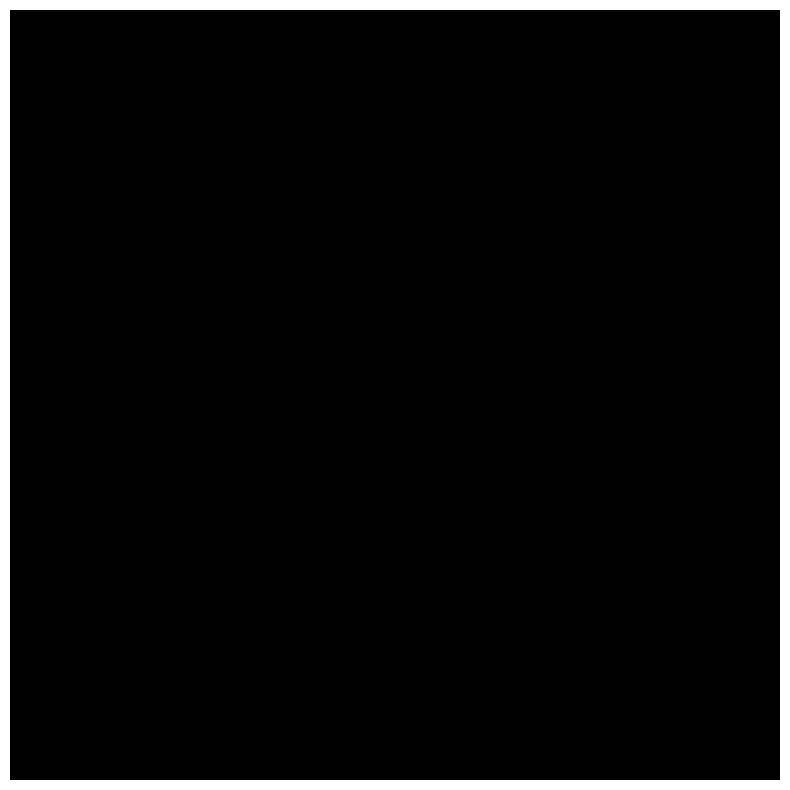

In [88]:
point_cloud = o3d.geometry.PointCloud()

# ply_len_limit
for i in tqdm(range(start_index, 1 ,frame_step)):
    depth_file_name = depth_files[i]
    frame_id = int(depth_file_name.split('.')[0])
    ply_file_path = os.path.join(ply_path, str(frame_id) + ".ply")

    pose = extrinsics[frame_id]
    position = pose[:3, 3]
    orientation = pose[:3, :3]

    pcd = o3d.io.read_point_cloud(ply_file_path)
    # point_cloud += pcd

    rasterizeP3D(pcd, pose)

# coordinate_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(size=0.5, origin=position, frame=orientation)

# axes = o3d.geometry.TriangleMesh.create_coordinate_frame(size=1, origin=position)
# o3d.visualization.draw_geometries([point_cloud, axes])

pcd = None
point_cloud = None
axes = None